# Домашнее задание по мини-курсу "Анализ и обработка веб-данных на Python"

В качестве ДЗ я решил написать web-scraper, который соберет информацию обо всех образовательных программах бакалавриата московского кампуса ВШЭ и будет парсить страницы с рейтингами студентов этих программ, представляя их в удобном для обработки и анализа виде.

С помощью этого скрапера и пакета ```matplotlib``` я соберу, проанализирую и визуализирую данные о среднем показателе GPA (Grade Point Average), а также о среднем количестве отчисленных студентов по всем факультетам московской Вышки за 2018/2019, 2019/2020 и 2020/2021 учебные годы.

## 1. Первичный сбор данных

Сперва посмотрим на сайт образовательных программ Вышки и поймем, как можно достать оттуда нужные нам данные.

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
url = 'https://www.hse.ru/education/msk/bachelor/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
print(soup.prettify())

Получим список всех образовательных программ и соотвествующих им факультетов, а также ссылки на страницы с описанием программ.
Для этого методом пристального взгляда найдем в html-коде выше ```div```-ы с нужными полями ```id``` и ```class``` и пройдемся по ним:

In [ ]:
programs_html = soup('div', id='education-programs__list')[0]
programs = programs_html('div', 'edu-programm__item')
for program in programs:
    faculty = program('div', 'edu-programm__unit')[0]('span')[1].text
    name = program.a.text
    url = program.a['href']
    print(faculty, name, url, sep=' | ')

Факультет городского и регионального развития | Городское планирование | https://www.hse.ru/ba/up/
Факультет биологии и биотехнологии | Клеточная и молекулярная биотехнология | https://www.hse.ru/ba/cmb/
Институт классического Востока и античности | Арабистика: язык, словесность, культура | https://www.hse.ru/ba/arabic/
Факультет мировой экономики и мировой политики | Востоковедение | https://www.hse.ru/ba/oriental/
Санкт-Петербургская школа социальных наук и востоковедения | Востоковедение | https://spb.hse.ru/ba/oriental/
Институт классического Востока и античности | Христианский Восток | https://www.hse.ru/ba/christian/
Институт классического Востока и античности | Язык, словесность и культура Китая | https://www.hse.ru/ba/chinese/
Факультет коммуникаций, медиа и дизайна, Школа дизайна | Дизайн | https://design.hse.ru/ba/program/design
Школа дизайна, Санкт-Петербургская школа гуманитарных наук и искусств | Дизайн | https://spb.hse.ru/ba/designs/
Факультет гуманитарных наук | Дизайн 

Видим, что несмотря на то, что в изначальном url-е было явно указано ```...msk/bachelor```, в html-коде имеются программы не только из Москвы и не только бакалаврские. Поймем, как отфильтровать лишнее. Для этого взглянем на ```div```-ы, отвечающие одной ОП:

In [ ]:
def program_info(index):
    program = programs[index]
    print(program('div', 'edu-programm__unit')[0]('span')[0].text)
    print(program.prettify())


program_info(10)
program_info(-1)

Пермь
<div class="b-row edu-programm__item" data-filters='[122472763,51999666,91519646,"54.00.00 Изобразительное искусство и прикладные виды искусств","ru","p","pf","full","online","Дизайн","crcmp","rl","literature"]' style="display: none;">
 <div class="b-row__item b-row__item--6 b-row__item--t12">
  <a class="link" href="https://perm.hse.ru/ba/design/">
   Дизайн
  </a>
  <div class="edu-programm__unit">
   <span class="edu-programm__city with-icon with-icon_flag-perm">
    Пермь
   </span>
   <span class="grey">
    Социально-гуманитарный факультет
   </span>
  </div>
 </div>
 <div class="b-row__item b-row__item--2 b-row__item--t4 b-row__item--period">
  <div class="edu-programm__data u-accent">
   4 года
  </div>
  <div class="edu-programm__edu_offline">
   Очная
  </div>
 </div>
 <div class="b-row__item b-row__item--4 b-row__item--t8 b-row__item--places">
  <div class="b-row__item--place">
   <div class="edu-programm__data u-accent edu-program-places" style="display:none;">
    50

Отфильтровать по городу просто: соответствующий ```span``` имеется в коде выше. Но как понять из него, является ОП бакалаврской или магистерской? Кажется, самый простой спрособ это сделать &mdash; посмотреть на ссылку на страницу ОП: если она содержит ```ba```, значит это бакалавриат.

В процессе первичной обработки обнаружилась проблема. Большинство страниц ОП имеют ссылки в домене просто ```hse.ru```, и с ними всё в порядке: формат ссылок один и тот же и, самое главное, страницы с рейтингами имеют одинаковый вид. Но для некоторых программ и формат ссылок, и страницы с рейтинами выглядят по-другому. Посмотрим на них:

In [ ]:
for program in programs:
    town, faculty = [program('div', 'edu-programm__unit')[0]('span')[i].text for i in [0, 1]]
    url = program.a['href']
    name = program.a.text
    if town == 'Москва' and url.split('/')[2] != 'www.hse.ru':
        print(faculty, name, url, sep=' | ')

Факультет коммуникаций, медиа и дизайна, Школа дизайна | Дизайн | https://design.hse.ru/ba/program/design
Факультет коммуникаций, медиа и дизайна, Школа дизайна | Мода | https://design.hse.ru/ba/program/fashion
Факультет коммуникаций, медиа и дизайна | Современное искусство | https://art.hse.ru/ba
Факультет коммуникаций, медиа и дизайна, Школа дизайна | Дизайн | http://design.hse.ru/mag-design
Факультет коммуникаций, медиа и дизайна | Дизайн интерьера | https://design.hse.ru/ma/program/interior
Факультет коммуникаций, медиа и дизайна, Школа дизайна | Коммуникационный и цифровой дизайн | http://design.hse.ru/mag-comm
Факультет коммуникаций, медиа и дизайна, Школа дизайна | Мода | http://design.hse.ru/mag-fashion
Школа дизайна | Практики современного искусства | http://art.hse.ru/ma
Школа дизайна | Современный дизайн в преподавании изобразительного искусства и технологии в школе | http://design.hse.ru/pages/184


Как видно, из бакалаврских программ "нерегулярных" всего 3. Их страницы лежат в доменах ```design.hse.ru``` и ```art.hse.ru```. Не будем с ними заморачиваться и просто отфильтруем :)

In [ ]:
def sanitize_str(s):
    return s.strip().replace('\xa0', ' ')


faculties = {}
for program in programs:
    town, faculty = [sanitize_str(program('div', 'edu-programm__unit')[0]('span')[i].text) for i in [0, 1]]
    url = program.a['href'].split('/')
    if (town == 'Москва') and ('ba' in url) and (url[2] == 'www.hse.ru'):
        name = sanitize_str(program.a.text)
        code = url[-2]
        if faculty not in faculties:   
            faculties[faculty] = set()
        faculties[faculty].add((name, code))
faculties

{'Факультет городского и регионального развития': {('Городское планирование',
   'up')},
 'Факультет биологии и биотехнологии': {('Клеточная и молекулярная биотехнология',
   'cmb')},
 'Институт классического Востока и античности': {('Античность', 'antiq'),
  ('Арабистика: язык, словесность, культура', 'arabic'),
  ('Христианский Восток', 'christian'),
  ('Язык, словесность и культура Китая', 'chinese')},
 'Факультет мировой экономики и мировой политики': {('Востоковедение',
   'oriental'),
  ('Международные отношения', 'ia'),
  ('Мировая экономика', 'we'),
  ('Программа двух дипломов НИУ ВШЭ и Лондонского университета по международным отношениям',
   'ir'),
  ('Программа двух дипломов НИУ ВШЭ и Университета Кёнхи «Экономика и политика в Азии»',
   'epa')},
 'Московский институт электроники и математики им. А.Н. Тихонова': {('Информатика и вычислительная техника',
   'isct'),
  ('Компьютерная безопасность', 'cosec'),
  ('Прикладная математика', 'am')},
 'Факультет компьютерных наук': {

Итак, мы распарсили и отфильтровали факультеты и реализуемые на них ОП. Кроме того, для каждой ОП мы получили ее "код", используемый в ссылке на ее страницу, где, в свою очередь, хранятся нужные нам рейтинги. Например, для ПМИ страница с рейтингами находится по адресу https://www.hse.ru/ba/ami/ratings. Для остальных ("регулярных") ОП аналогично.

Приступим к парсингу страниц с рейтингами (на примере ПМИ):

In [ ]:
query_facutly = 'Факультет компьютерных наук'
query_program = 'Прикладная математика и информатика'
query_course = 2
query_rating = 'Кумулятивный рейтинг по итогам 1-2 модулей 2020/2021 уч.г.'

code = [prog[1] for prog in faculties[query_facutly] if prog[0] == query_program][0]
rating_url = f'https://www.hse.ru/ba/{code}/ratings'
response = requests.get(rating_url)
soup = BeautifulSoup(response.content, 'html.parser')
print(soup.prettify())

Тем же методом пристального взгляда находим блок, хранящий все доступные на данный момент рейтинги:

In [ ]:
options = soup('div', 'first_child last_child')
options[0]('select')[0]('option')

[<option selected="" value="488315638">Текущий рейтинг 2020/2021 учебного года (3-4 модули)</option>,
 <option value="488315636">Рейтинг выпускников 2020/2021 уч.г.</option>,
 <option value="454146718">Кумулятивный рейтинг по итогам 1-2 модулей 2020/2021 уч.г.</option>,
 <option value="450612123">Текущий рейтинг после пересдач 2020/2021 учебного года (1-2 модули)</option>,
 <option value="436052040">Текущий рейтинг 2020/2021 учебного года (1-2 модули)</option>,
 <option value="436052038">Рейтинг выпускников 2019/2020 уч.г.</option>,
 <option value="414185556">Кумулятивный рейтинг по итогам 3-4 модулей 2019/2020 уч.г.</option>,
 <option value="412769365">Текущий рейтинг после пересдач 2019/2020 учебного года (3-4 модули)</option>,
 <option value="381346749">Текущий рейтинг 2019/2020 учебного года (3-4 модули)</option>,
 <option value="351900289">Кумулятивный рейтинг по итогам 1-2 модулей 2019/2020 уч.г.</option>,
 <option value="348116371">Текущий рейтинг после пересдач 2019/2020 учебно

и номера курсов:

In [ ]:
for option in options[0]('select')[1]('option'):
    print(option['value'])

1
2
3
4


Как видим, у каждого рейтинга есть своё ```value```, которое как раз нужно для того, чтобы получить страницу с соответствующим рейтингом:

In [ ]:
url_from = None
for rating in options[0]('option'):
    if rating.text == query_rating:
        url_from = rating['value']
        break
rating_url = f'https://www.hse.ru/ba/{code}/ratings?from={url_from}&course={query_course}'
response = requests.get(rating_url)
soup = BeautifulSoup(response.content, 'html.parser')
print(soup.prettify())

Осталось найти в этом html-коде, собственно, табличку с рейтингом и вычленить из неё всю информацию:

In [ ]:
names = []
places = []
grade_mids = []
grade_mins = []
percentiles = []
grade_gpas = []

for tr in soup('table')[0]('tr')[1:]:
    names.append(tr('td')[0].text)
    places.append(tr('td')[1].text)
    grade_mids.append(float(tr('td')[2].text))
    grade_mins.append(int(tr('td')[3].text))
    percentiles.append(float(tr('td')[4].text[:-1]))
    grade_gpas.append(float(tr('td')[5].text))

Соберём из полученных данных ```pandas```-овский датафрейм:

In [ ]:
import pandas as pd


rating = pd.DataFrame(
    {
        'Студент': names,
        'Позиция в рейтинге': places,
        'Средний балл': grade_mids,
        'Минимальный балл': grade_mins,
        'Перцентиль': percentiles,
        'GPA': grade_gpas
    }
)
rating

,Студент,Позиция в рейтинге,Средний балл,Минимальный балл,Перцентиль,GPA
0,Смородинов Александр Андреевич,1,9.03,6,0.00,9.09
1,Буклей Григорий Александрович,2,9.21,7,0.34,9.17
2,Поздеев Дмитрий Михайлович,3,9.15,5,0.69,9.16
3,Иваник Даниил Иванович,4,9.33,7,1.03,9.32
4,Колодезный Александр Анатольевич,5,9.35,7,1.38,9.33
...,...,...,...,...,...,...
285,Гладких Роман Евгеньевич,286,5.40,4,98.28,5.18
286,Лукомский Вячеслав Игоревич,287,5.63,4,98.62,5.11
287,Ярусский Илья Михайлович,288,5.25,4,98.97,4.64
288,Игнатович Денис Сергеевич,289,5.21,4,99.31,4.59


и заодно посмотрим на его матрицу корреляций:

In [ ]:
rating.corr()

,Средний балл,Минимальный балл,Перцентиль,GPA
Средний балл,1.000000,0.831815,-0.926766,0.993986
Минимальный балл,0.831815,1.000000,-0.794639,0.817710
Перцентиль,-0.926766,-0.794639,1.000000,-0.927272
GPA,0.993986,0.817710,-0.927272,1.000000


Весьма близкие по модулю к 1 попарные коэффициенты корреляций между GPA, средним баллом и перцентилем не вызывают удивления: логично, что чем больше средний и средневзвешенный баллы у студента, тем выше он в рейтинге $ \implies $ тем меньше его перцентиль. Однако эти показатели, в свою очередь, не столь сильно коррелируют с минимальным баллом. Это тоже объяснимо: например, у студента могут быть высокие оценки по всем дисциплинам, кроме одной. Понятно, что она не будет вносить существенного вклада (тем более, если весит мало кредитов) в средний балл, и студент всё равно будет довольно высоко в рейтинге.

## 2. Написание классов веб-скрапера и функций для сбора данных

Теперь, уже имея представление о том, что делать с нужными нам веб-страницами, реализуем общий интерфейс для получения рейтингов.

Нам потребуется исключение, которое мы будем кидать в случае, когда не удалось получить запрошенную страницу:

In [ ]:
class BadResponseError(Exception):
    def __init__(self, response_code: int):
        self.response_code = response_code
    
    def __str__(self):
        return f'Bad response status code: {self.response_code}'

а также класс для парсинга страницы с помощью ```Beautiful Soup```:

In [ ]:
class BeautifulSoupHtmlParser:
    OK_RESPONSE_STATUS = 200
    
    def __init__(self, parser: str):
        self.parser = parser
    
    def __call__(self, url: str) -> BeautifulSoup:
        response = requests.get(url)
        if response.status_code != BeautifulSoupHtmlParser.OK_RESPONSE_STATUS:
            raise BadResponseError(response.status_code)
        return BeautifulSoup(response.content, self.parser)

**Класс, реализующий скрапинг страницы с образовательными программами:**

In [ ]:
from typing import Tuple, Dict, Set


class HseEduProgramsWebScraper:
    TARGET_TOWNS = ['Москва']
    REGULAR_DOMAINS = ['www.hse.ru']
    URL = 'https://www.hse.ru/education/msk/bachelor/'
    
    @staticmethod
    def sanitize_str(s: str) -> str:
        return s.strip().replace('\xa0', ' ')
        
    def __init__(self):
        self.faculties = {}
        self.programs = {}
        self.loaded = False
        
    def get(self) -> Tuple[Dict[str, Set[str]], Dict[str, str]]:
        if self.loaded:
            return self.faculties, self.programs
        
        parser = BeautifulSoupHtmlParser('html.parser')
        try:
            soup = parser(HseEduProgramsWebScraper.URL)
        except BadResponseError:
            raise
        programs_html = soup('div', id='education-programs__list')[0]
        for program in programs_html('div', 'edu-programm__item'):
            town, faculty = [sanitize_str(program('div', 'edu-programm__unit')[0]('span')[i].text) for i in [0, 1]]
            url = program.a['href'].split('/')
            if (town in HseEduProgramsWebScraper.TARGET_TOWNS) and ('ba' in url) and \
               (url[2] in HseEduProgramsWebScraper.REGULAR_DOMAINS):
                name = sanitize_str(program.a.text)
                code = url[-2]
                self.programs[name] = code
                if faculty not in self.faculties:   
                    self.faculties[faculty] = set()
                self.faculties[faculty].add(name)
        
        # Из-за особенностей полученных данных, необходимо отождествить все пары факультетов,
        # название одного из которых является префиксом другого
        duplicates = []
        for faculty_i in self.faculties:
            for faculty_j in self.faculties:
                if faculty_i != faculty_j and faculty_i.find(faculty_j) != -1:
                    for program in self.faculties[faculty_i]:
                        self.faculties[faculty_j].add(program)
                    duplicates.append(faculty_i)
        for dup in duplicates:
            self.faculties.pop(dup)
        
        self.loaded = True
        return self.faculties, self.programs

**Класс, реализующий скрапинг страниц с рейтингами:**

In [ ]:
class HseRatingGetter:
    def __init__(self, program: str, scraper: HseEduProgramsWebScraper):
        programs = scraper.get()[1]
        if program not in programs:
            raise ValueError('There is no such program in educational program list')
        self.url_code = programs[program]
        
    def __call__(self, rating_name: str, course: int) -> pd.DataFrame:
        parser = BeautifulSoupHtmlParser('html.parser')
        url = f'https://www.hse.ru/ba/{self.url_code}/ratings'
        try:
            soup = parser(url)
        except BadResponseError:
            raise
        url_from = None
        for option in soup('div', 'first_child last_child')[0]('select')[0]('option'):
            if option.text == rating_name:
                url_from = option['value']
                break
        else:
            raise ValueError('Irregular rating page or incorrect rating name')
        for option in soup('div', 'first_child last_child')[0]('select')[1]('option'):
            if course == int(option['value']):
                break
        else:
            raise ValueError('Incorrect course value')
        
        url = f'https://www.hse.ru/ba/{self.url_code}/ratings?from={url_from}&course={course}'
        try:
            soup = parser(url)
        except BadResponseError:
            raise
        names = []
        positions = []
        grade_mids = []
        grade_mins = []
        percentiles = []
        gpas = []
        for tr in soup('table')[0]('tr')[1:]:
            names.append(tr('td')[0].text)
            positions.append(tr('td')[1].text)
            if tr('td')[2].text != '':
                grade_mids.append(float(tr('td')[2].text))
            else:
                grade_mids.append(float('nan'))
            if tr('td')[3].text != '':
                grade_mins.append(int(tr('td')[3].text))
            else:
                grade_mins.append(float('nan'))
            percentiles.append(float(tr('td')[4].text[:-1]))
            gpas.append(float(tr('td')[5].text))
        
        res = pd.DataFrame(
            {
                'Студент': names,
                'Позиция в рейтинге': positions,
                'Средний балл': grade_mids,
                'Минимальный балл': grade_mins,
                'Перцентиль': percentiles,
                'GPA': gpas
            }
        )
        return res

Проверим, что всё работает:

In [ ]:
scraper = HseEduProgramsWebScraper() # всегда используется далее для передачи в конструктор объекта типа HseRatingGetter

rating_getter = HseRatingGetter('Культурология', scraper)
rating = rating_getter('Кумулятивный рейтинг по итогам 1-2 модулей 2020/2021 уч.г.', 3)
rating.head()

,Студент,Позиция в рейтинге,Средний балл,Минимальный балл,Перцентиль,GPA
0,Борисова Дарья Александровна,1,7.03,4,0.00,6.85
1,Чефанова Елизавета Игоревна,2,9.42,7,1.96,9.48
2,Кожаринова Мария Викторовна,3,9.51,8,3.92,9.51
3,Кузнецова Яна Михайловна,4,8.98,6,5.88,9.11
4,Болгарина Дарья Александровна,5,8.93,6,7.84,9.06


Видим, что у человека на первом месте слишком низкие показатели по сравнению с теми, кто ниже. На самом деле, это распространённое явление. Кажется, что это результат технических ошибок при формировании рейтинга. Но на наш дальнейший анализ это не повлияет, поэтому оставим как есть.

Однако бывают случаи совсем странные, когда у человека средний балл меньше минимального. Очевидно, такого не может быть, поэтому, для чистоты анализа, будем фильтровать таких студнетов. Также отфильтруем тех, у кого по какой-то причине хотя бы одно поле было не заполнено. Напишем соответствующую функцию:

In [ ]:
def sanitized_rating(rating: pd.DataFrame) -> pd.DataFrame:
    rating.dropna(inplace=True)
    return rating[rating['Средний балл'] >= rating['Минимальный балл']]

Проверим:

In [ ]:
rating_getter = HseRatingGetter('Прикладная математика и информатика', scraper)
rating = rating_getter('Текущий рейтинг после пересдач 2018/2019 уч.г. (3-4 модули)', 2)
print(len(rating), len(sanitized_rating(rating)))

225 223


Теперь, для удобства, забьём названия всех доступных на данный момент рейтингов в словарь:

In [ ]:
RATING_NAME = {
    2018: {
        1: {
            'cr':  'Текущий рейтинг 2018/2019уч.г. (1 семестр)',
            'crr': 'Текущий рейтинг после пересдач 2018/2019уч.г. (1-2 модули)',
            'cm':  'Кумулятивный рейтинг по итогам 1-2 модулей 2018/2019 уч.г.'
        },
        2: {
            'cr':  'Текущий рейтинг 2018/2019 учебного года (3-4 модули)',
            'crr': 'Текущий рейтинг после пересдач 2018/2019 уч.г. (3-4 модули)',
            'cm':  'Кумулятивный рейтинг по итогам 3-4 модулей 2018/2019 уч.г.',
            'gr':  'Рейтинг выпускников 2018/2019 уч.г.'
        }
    },
    2019: {
        1: {
            'cr':  'Текущий рейтинг 2019/2020 учебного года (1-2 модули)',
            'crr': 'Текущий рейтинг после пересдач 2019/2020 учебного года (1-2 модули)',
            'cm':  'Кумулятивный рейтинг по итогам 1-2 модулей 2019/2020 уч.г.'
        },
        2: {
            'cr':  'Текущий рейтинг 2019/2020 учебного года (3-4 модули)',
            'crr': 'Текущий рейтинг после пересдач 2019/2020 учебного года (3-4 модули)',
            'cm':  'Кумулятивный рейтинг по итогам 3-4 модулей 2019/2020 уч.г.',
            'gr':  'Рейтинг выпускников 2019/2020 уч.г.'
        }
    },
    2020: {
        1: {
            'cr':  'Текущий рейтинг 2020/2021 учебного года (1-2 модули)',
            'crr': 'Текущий рейтинг после пересдач 2020/2021 учебного года (1-2 модули)',
            'cm':  'Кумулятивный рейтинг по итогам 1-2 модулей 2020/2021 уч.г.'
        },
        2: {
            'cr':  'Текущий рейтинг 2020/2021 учебного года (3-4 модули)',
            'gr':  'Рейтинг выпускников 2020/2021 уч.г.'
        }
    }
}

Приступим к написанию функций, с помощью которых мы соберём и проанализируем интересующие нас данные.  
**Функция для вычисления среднего GPA** (использует текущий рейтинг до пересдач запрошенного периода):

In [ ]:
def mean_gpa(program: str, year: int, term: int, course: int, scraper: HseEduProgramsWebScraper) -> float:
    rating_getter = HseRatingGetter(program, scraper)
    rating = rating_getter(RATING_NAME[year][term]['cr'], course)
    rating = sanitized_rating(rating)
    if rating.empty:
        return -1
    return rating['GPA'].mean()

In [ ]:
mean_gpa('Программная инженерия', 2020, 1, 2, scraper)

6.795770750988143

Теперь напишем **функцию для подсчёта числа отчисленных студентов за данный учебный год**. Считаем, что студент отчислен, если в некотором текущем рейтинге до пересдач запись о нем имеется, а в текущем рейтинге того же периода после пересдач &mdash; не имеется.

In [ ]:
from typing import List


def calculate_rating_difference(names_cr: List[str], names_crr: List[str]) -> int:
    expelled = 0
    for student in names_cr:
        if student not in names_crr:
            expelled += 1
    return expelled


def count_expelled(program: str, year: int, course: int, scraper: HseEduProgramsWebScraper) -> int:
    rating_getter = HseRatingGetter(program, scraper)
    rating_cr_1 = rating_getter(RATING_NAME[year][1]['cr'], course)
    rating_crr_1 = rating_getter(RATING_NAME[year][1]['crr'], course)
    if rating_cr_1.empty or rating_crr_1.empty:
        return -1
    res_1 = calculate_rating_difference(list(rating_cr_1['Студент']), list(rating_crr_1['Студент']))
    
    res_2 = 0
    if year != 2020 or course == 4: # пересдачи за 2020/2021 учебный год на данный момент еще не состоялись
        rating_cr_2 = rating_getter(RATING_NAME[year][2]['cr'], course)
        rating_crr_2 = rating_getter(RATING_NAME[year][2]['crr'], course + 1) if course < 4 else \
                       rating_getter(RATING_NAME[year][2]['gr'], course)
        res_2 = calculate_rating_difference(list(rating_cr_2['Студент']), list(rating_crr_2['Студент']))

    return res_1 + res_2

In [ ]:
count_expelled('Мировая экономика', 2020, 2, scraper)

6

## 3. Сбор, анализ и визуализация данных

Для начала сгенерируем сокращения для названий факультетов, чтобы они помещались на графиках:

In [ ]:
faculties = scraper.get()[0]
alias = {}
for faculty in faculties:
    alias[faculty] = ''.join([token[0].upper() for token in faculty.split() if token != 'и'])

# поправим некоторые сокращения
alias['Факультет мировой экономики и мировой политики'] = 'ФМЭиМП'
alias['Московский институт электроники и математики им. А.Н. Тихонова'] = 'МИЭМ'
alias

{'Факультет городского и регионального развития': 'ФГРР',
 'Факультет биологии и биотехнологии': 'ФББ',
 'Институт классического Востока и античности': 'ИКВА',
 'Факультет мировой экономики и мировой политики': 'ФМЭиМП',
 'Московский институт электроники и математики им. А.Н. Тихонова': 'МИЭМ',
 'Факультет компьютерных наук': 'ФКН',
 'Факультет гуманитарных наук': 'ФГН',
 'Факультет математики': 'ФМ',
 'Факультет географии и геоинформационных технологий': 'ФГГТ',
 'Факультет социальных наук': 'ФСН',
 'Факультет коммуникаций, медиа и дизайна': 'ФКМД',
 'Факультет физики': 'ФФ',
 'Факультет химии': 'ФХ',
 'Высшая школа бизнеса': 'ВШБ',
 'Международный институт экономики и финансов': 'МИЭФ',
 'Факультет экономических наук': 'ФЭН',
 'Факультет права': 'ФП',
 'Школа иностранных языков': 'ШИЯ'}

Теперь приступим к сбору и анализу интересующих нас данных. Для всех факультетов за каждый учебный год (для которого доступен рейтинг на соответствующей странице) для каждого курса будем усреднять среднее GPA и количество отчисленных студентов по всем ОП, реализуемым на данном факультете:

In [ ]:
means = {
    2018: {}, 2019: {}, 2020: {}
}
expelled = {
    2018: {}, 2019: {}, 2020: {}
}

for year in [2018, 2019, 2020]:
    print(year)
    for course in [1, 2, 3, 4]:
        print('-', course)
        means[year][course] = {}
        expelled[year][course] = {}
        for faculty in faculties:
            print('--', alias[faculty])
            mean_sum = 0
            mean_cnt = 0
            exp_sum = 0
            exp_cnt = 0
            for program in faculties[faculty]:
                print('---', program)
                try:
                    m = [mean_gpa(program, year, term, course, scraper) for term in [1, 2]]
                    cnt = count_expelled(program, year, course, scraper)
                except Exception as e:
                    print(str(e))
                    continue
                if m[0] != -1 and m[1] != -1:
                    mean_sum += (m[0] + m[1]) / 2
                    mean_cnt += 1
                if cnt != -1:
                    exp_sum += cnt
                    exp_cnt += 1
            means[year][course][alias[faculty]] = mean_sum / mean_cnt if mean_cnt != 0 else -1        
            expelled[year][course][alias[faculty]] = exp_sum / exp_cnt if exp_cnt != 0 else -1
            print('--', f'mean = {means[year][course][alias[faculty]]}, exp = {expelled[year][course][alias[faculty]]}')

In [ ]:
means, expelled

Визуализируем полученное:

In [ ]:
import matplotlib.pyplot as plt


def plot_data(year: int, data: Dict[int, Dict[int, Dict[str, int]]], title: str, ylim: Tuple[int, int]):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.suptitle(title + f' за {year}/{year + 1} учебный год')
    sbp = [fig.add_subplot(1, 4, i) for i in [1, 2, 3, 4]]
    for i in range(0, 4):
        sbp[i].set(title=f'{i + 1} курс')
        sbp[i].scatter(data[year][i + 1].keys(), data[year][i + 1].values())
        sbp[i].tick_params(labelrotation=90)
        if ylim is not None:
            sbp[i].set_ylim(ylim)

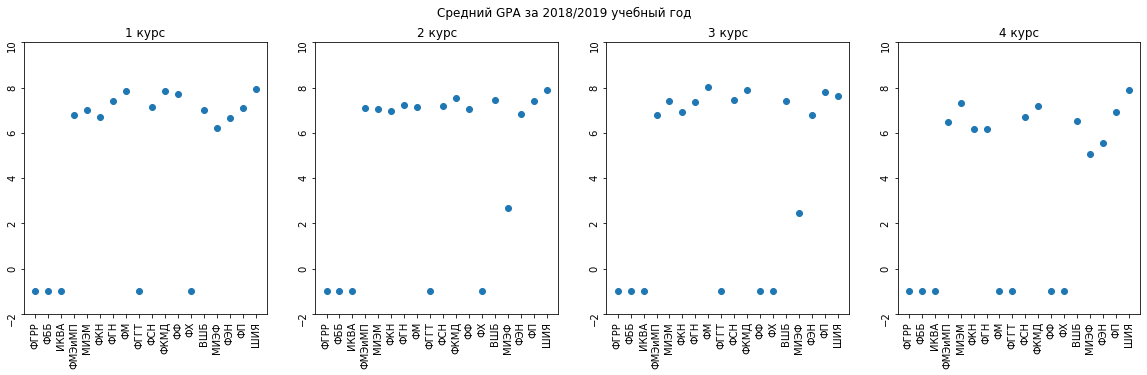

In [ ]:
plot_data(2018, means, 'Средний GPA', (-2, 10))

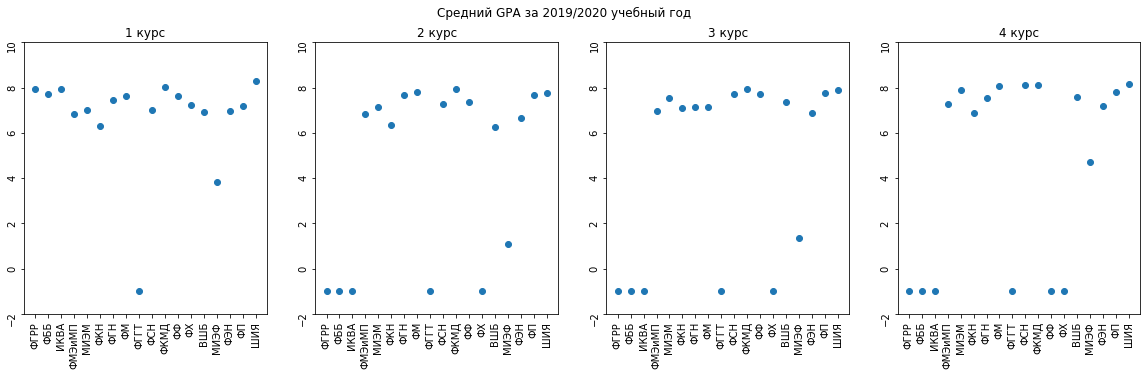

In [ ]:
plot_data(2019, means, 'Средний GPA', (-2, 10))

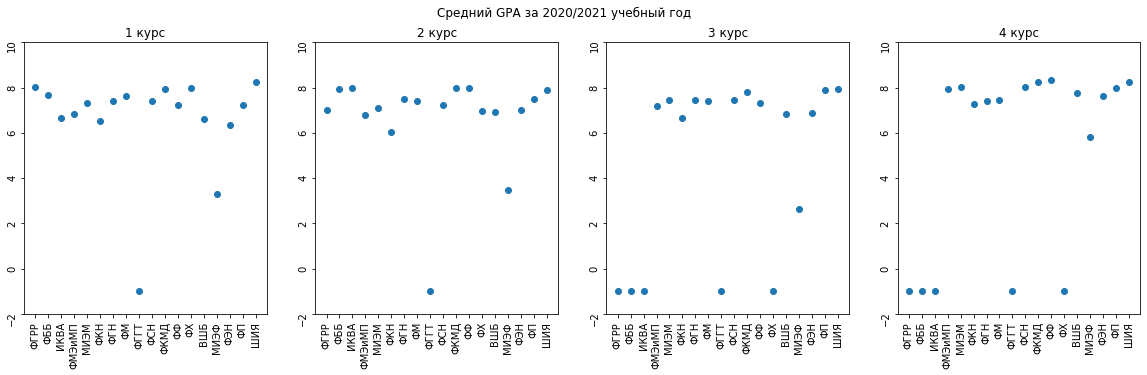

In [ ]:
plot_data(2020, means, 'Средний GPA', (-2, 10))

Итак, первое, что бросается в глаза, &mdash; минус единицы. Больше всего их в 2018/2019 учебном году. Дело в том, что на тот момент соответствующих факультетов еще просто не было, либо же они появились недавно и на них пока нет студентов старших курсов. Единственная странность тут, что -1 также стоит на 4 курсе Факультета математики (основанном в 2007 году). Взглянем на соответсвующий рейтинг:

In [ ]:
rating_getter = HseRatingGetter('Математика', scraper)
rating = rating_getter('Текущий рейтинг 2018/2019 учебного года (3-4 модули)', 4)
rating

,Студент,Позиция в рейтинге,Средний балл,Минимальный балл,Перцентиль,GPA
0,Рогачевская Анастасия Вадимовна,1,1.67,4,0.0,1.28


In [ ]:
len(sanitized_rating(rating))

0

Видим, что весь рейтинг представляет собой всего одну запись, которая еще и фильтруется нашей функцией ```sanitized_rating```. Скорее всего, это результат технической ошибки, или, возможно, кто-то забыл выгрузить нужный рейтинг из ЛМС ¯\\_(ツ)_/¯

В следующих учебных годах, как видно, минус единиц становится всё меньше.

Можно сказать, что в среднем (если не считать МИЭФ) студенты учатся примерно на 7. Самые высокие оценки в среднем на ФКМД и ШИЯ. А на родном ФКНе оценки в среднем ниже, чем на большинстве факультетов.

Что касается выбросов по МИЭФу, то при первом взгляде на один из самых свежих рейтингов, сразу складывается ощущение, что это определенно какие-то технические ошибки:

In [ ]:
rating_getter = HseRatingGetter('Программа двух дипломов по экономике НИУ ВШЭ и Лондонского университета', scraper)
rating = rating_getter('Текущий рейтинг 2020/2021 учебного года (3-4 модули)', 3)
rating

,Студент,Позиция в рейтинге,Средний балл,Минимальный балл,Перцентиль,GPA
0,Ёлшина Елена Александровна,1,2.22,10.0,0.00,1.90
1,Адзхед Мария Томасовна,2,2.11,9.0,0.42,1.81
2,Глазков Антон Андреевич,3,2.00,9.0,0.84,1.71
3,Морозов Григорий Андреевич,4,2.22,9.0,1.26,1.71
4,Шерифф Нил Сахейм,5,2.11,9.0,1.68,1.61
...,...,...,...,...,...,...
233,Шатских Анастасия Максимовна,111 - 238,0.00,NaN,100.00,0.00
234,Шерстюк Сергей Дмитриевич,111 - 238,0.00,NaN,100.00,0.00
235,Шиваров Александр Александрович,111 - 238,0.00,NaN,100.00,0.00
236,Шуклин Фёдор Андреевич,111 - 238,0.00,9.0,100.00,0.00


In [ ]:
sanitized_rating(rating)

,Студент,Позиция в рейтинге,Средний балл,Минимальный балл,Перцентиль,GPA
48,Селищев Георгий Артурович,49,1.2,1.0,20.17,0.83


С другими текущими рейтингами до пересдач всё примерно так же. Поэтому, кажется, что полученные по МИЭФу данные считать достоверными нельзя.

Теперь визуализируем данные по отчисленным студентам:

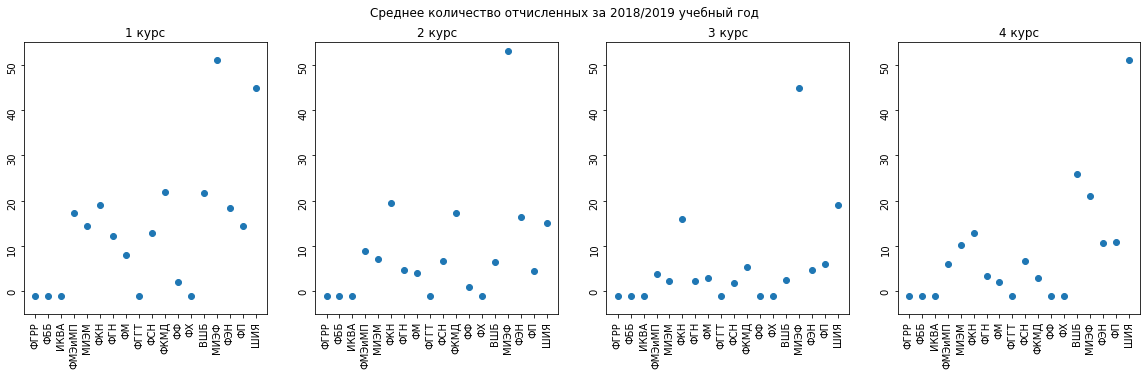

In [ ]:
plot_data(2018, expelled, 'Среднее количество отчисленных', (-5, 55))

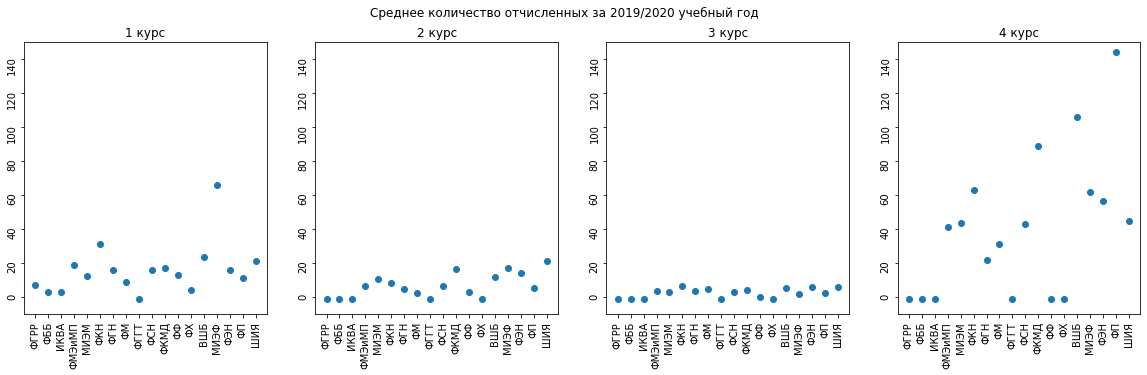

In [ ]:
plot_data(2019, expelled, 'Среднее количество отчисленных', (-10, 150))

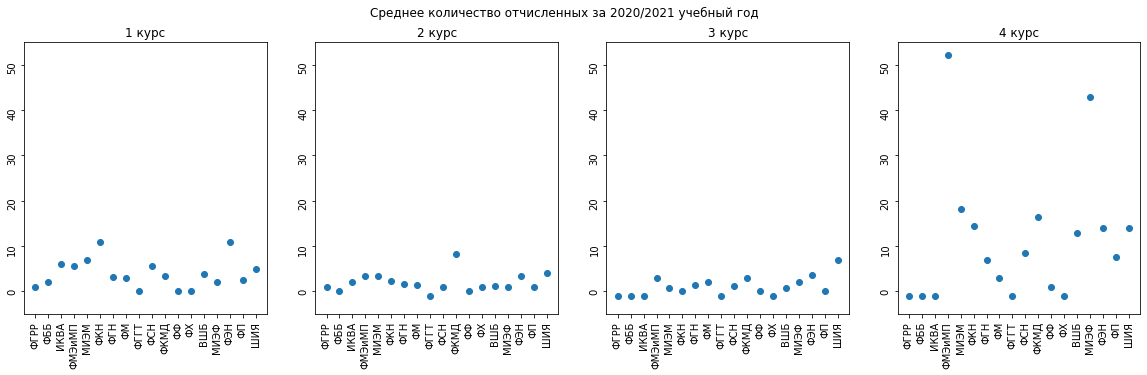

In [ ]:
plot_data(2020, expelled, 'Среднее количество отчисленных', (-5, 55))

В общем и целом (если не считать отдельные выбросы по тому же МИЭФу и 4 курс), картина получилась довольно реалистичная.

С МИЭФом, думаю, все ясно, причина та же, скорее всего.

Можно сказать, что в среднем меньше всего отчисляются на 3 курсе. Но примечательно, что довольно много студентов отчисляются на 4 курсе. Это может быть связано с теми же техническими ошибками. Или же моё, в общем-то, довольно логичное предположение о том, что рейтинг выпускников продолжает текущий рейтинг II семестра на 4 курсе неверное. В таком случае, у нас неполная картина и данные, стало быть, достоверными считать нельзя. Наконец, это вполне себе может быть реальностью, и тогда многие студенты, наверное, просто не выдерживают работу над дипломом ¯\\_(ツ)_/¯